#Overfitting

By Evgenia "Jenny" Nitishinskaya and Delaney Granizo-Mackenzie. Algorithms by David Edwards.

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)

Notebook released under the Creative Commons Attribution 4.0 License.

---

# What is overfitting?

When constructing a model, we tune both the parameters and the model by fitting to sample data. We then use the model and parameters to predict data we have not yet observed. We say a model is overfit when it is overly sensitive to noise and idiosyncracies in the sample data, and therefore does not reflect the underlying data-generating process.

To understand why this happens, one has to consider the amount of noise present in any dataset. One can consider a set of data as $D_{T}$, the true underlying data that came from whatever process we are trying to model, and $\epsilon$, some random noise. Because what we see is $D = D_{T} + \epsilon$, we might fit out model to very perfectly predict for the given $\epsilon$, but not for $D_{T}$.

This is problematic because we only care about fitting to the sample insofar as that gives an accurate fit to future data. The two broad causes of overfitting are:
* small sample size, so that noise and trend are not distinguishable
* choosing an overly complex model, so that it ends up contorting to fit the noise in the sample

##Verbal Example: Too Many Rules (Complexity)

Let's say you have the following dataset:

| TV Channel | Room Lighting Intensity | Enjoyment |
|------------|-------------------------|-----------|
| 1          | 2                       | 1         |
| 2          | 3                       | 2         |
| 3          | 1                       | 3         |

You are trying to predict enjoyment, so you create the following rules:

1. If TV Channel is 1 and Lighting Intensity is 2, then Enjoyment will be 1.
2. If TV Channel is 2 and Lighting Intensity is 3, then Enjoyment will be 2.
3. If TV Channel is 3 and Lighting Intensity is 1, then Enjoyment will be 3.
4. In all other cases predict an average enjoyment of 2.

This is a well defined model for future data, however, in this case let's say your enjoyment is purely dependent on the tv channel and not on the lighting. Because we have a rule for each row in our dataset, our model is perfectly predictive in our historical data, but would performly poorly in real trials because  we are overfitting to random noise in the lighting intensity data.

Generalizing this to stocks, if your model starts developing many specific rules based on specific past events, it is almost definitely overfitting. This is why black-box machine learning (neural networks, etc.) is so dangerous when not done correctly.

# Example: Curve fitting

Overfitting is most easily seen when we look at polynomial regression. Below we construct a dataset which noisily follows a quadratic. The linear model is underfit: simple linear models aren't suitable for all situations, especially when we have reason to believe that the data is nonlinear. The quadratic curve has some error but fits the data well.

When we fit a ninth-degree polynomial to the data, the error is zero - a ninth-degree polynomial can be constructed to go through any 10 points - but, looking at the tails of the curve, we know that we can't expect it to accurately predict other samples from the same distribution. It fits the data perfectly, but that is because it also fits the noise perfectly, and the noise is not what we want to model. In this case we have selected a model that is too complex.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels import regression
from scipy import poly1d

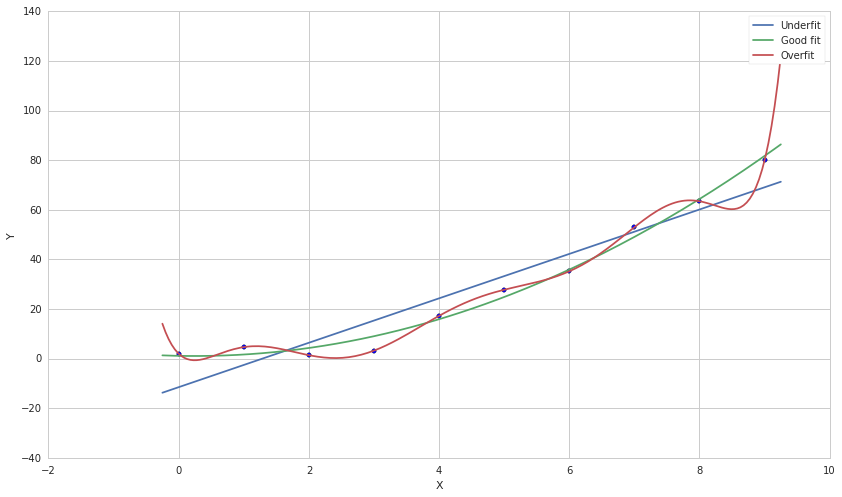

In [2]:
x = np.arange(10)
y = 2*np.random.randn(10) + x**2
xs = np.linspace(-0.25, 9.25, 200)

lin = np.polyfit(x, y, 1)
quad = np.polyfit(x, y, 2)
many = np.polyfit(x, y, 9)

plt.scatter(x, y)
plt.plot(xs, poly1d(lin)(xs))
plt.plot(xs, poly1d(quad)(xs))
plt.plot(xs, poly1d(many)(xs))
plt.ylabel('Y')
plt.xlabel('X')
plt.legend(['Underfit', 'Good fit', 'Overfit']);

When working with real data, there is unlikely to ever be a situation where a ninth-degree polynomial is appropriate: our choice of function should reflect a belief about the underlying process, and real-world processes generally do not follow high-degree polynomial curves. This example is contrived, but it can be tempting to use a quadratic or cubic model just to decrease sample error.

##Note: Model/Parameter Parsimony

Just as the most elegant physics models describe a tremendous amount of our world through a few equations, a good trading model should explain most of the data through a few rules. Any time you start to have a number of rules even close to the number of points in your data set, you can be sure you are overfitting. Since parameters can be thought of as rules as they equivalently constrain a model, the same is true of parameters. Fewer parameters is better, and it is better to explain 60% of the data with 2-3 paremeters than 90% with 10.

##Beware of the perfect fit

Because there is almost always noise present in real data, a perfect fit is almost always indicative of overfitting. It is almost impossible to know the percentage noise/signal in a given data set while you are developing the model, but use your common sense. Are the predictions surprisingly good? Then you're probably overfitting.

# Example: Regression parameters

How do we know which variables to include in a model? If we're afraid of omitting something important, we might try different ones and include all the variables we can find that improve the fit. Below we regress one asset that is in the same sector as the asset whose price we're trying to predict, and three other unrelated ones. In our initial timeframe, we are able to fit the model more closely to the data when using multiple variables than when using just one.

SLR R-squared: 0.72116650674
SLR p-value: 1.67466110861e-71
MLR R-squared: 0.818416145835
MLR p-value: 4.41409534058e-91


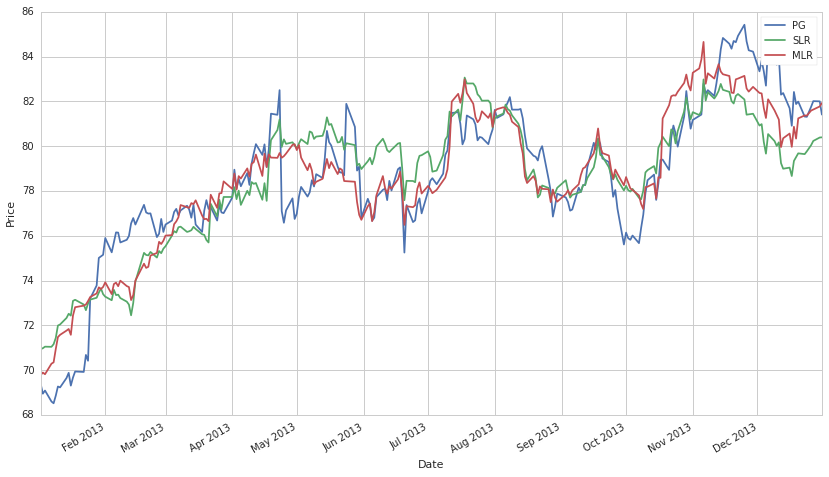

In [3]:
# Load one year's worth of pricing data for five different assets
start = '2013-01-01'
end = '2014-01-01'
x1 = get_pricing('PEP', fields='price', start_date=start, end_date=end)
x2 = get_pricing('MCD', fields='price', start_date=start, end_date=end)
x3 = get_pricing('ATHN', fields='price', start_date=start, end_date=end)
x4 = get_pricing('DOW', fields='price', start_date=start, end_date=end)
y = get_pricing('PG', fields='price', start_date=start, end_date=end)

# Build a linear model using only x1 to explain y
slr = regression.linear_model.OLS(y, sm.add_constant(x1)).fit()
slr_prediction = slr.params[0] + slr.params[1]*x1

# Run multiple linear regression using x1, x2, x3, x4 to explain y
mlr = regression.linear_model.OLS(y, sm.add_constant(np.column_stack((x1,x2,x3,x4)))).fit()
mlr_prediction = mlr.params[0] + mlr.params[1]*x1 + mlr.params[2]*x2 + mlr.params[3]*x3 + mlr.params[4]*x4

# Compute adjusted R-squared for the two different models
print 'SLR Adjusted R-squared:', slr.rsquared_adj
print 'SLR p-value:', slr.f_pvalue
print 'MLR Adjusted R-squared:', mlr.rsquared_adj
print 'MLR p-value:', mlr.f_pvalue

# Plot y along with the two different predictions
y.plot()
slr_prediction.plot()
mlr_prediction.plot()
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend(['PG', 'SLR', 'MLR']);

However, when we use the same estimated parameters to model a different time period, we find that the single-variable model fits worse, while the multiple-variable model is entirely useless. It seems that the relationships we found are not consistent and are particular to the original sample period.

SLR R-squared: 0.418512066544
MLR R-squared: -0.0158206433261


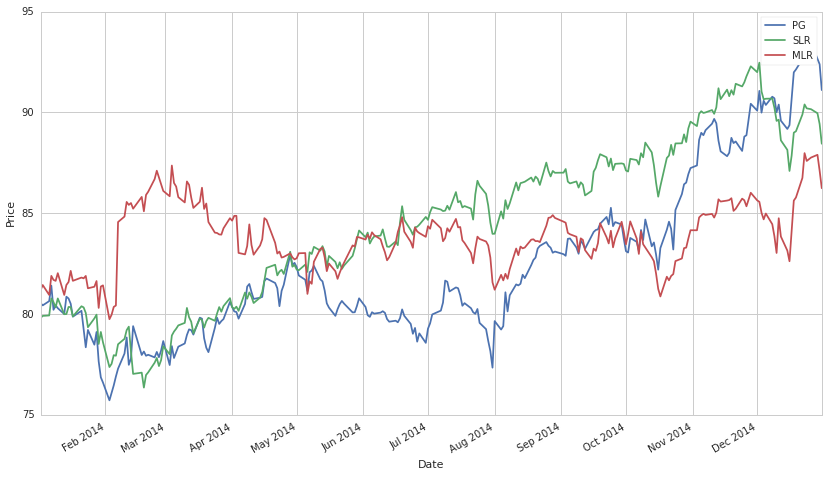

In [4]:
# Load the next of pricing data
start = '2014-01-01'
end = '2015-01-01'
x1 = get_pricing('PEP', fields='price', start_date=start, end_date=end)
x2 = get_pricing('MCD', fields='price', start_date=start, end_date=end)
x3 = get_pricing('ATHN', fields='price', start_date=start, end_date=end)
x4 = get_pricing('DOW', fields='price', start_date=start, end_date=end)
y = get_pricing('PG', fields='price', start_date=start, end_date=end)

# Extend our model from before to the new time period
slr_prediction2 = slr.params[0] + slr.params[1]*x1
mlr_prediction2 = mlr.params[0] + mlr.params[1]*x1 + mlr.params[2]*x2 + mlr.params[3]*x3 + mlr.params[4]*x4

# Manually compute adjusted R-squared over the new time period
adj = float(len(y) - 1)/(len(y) - 5) # Compute adjustment factor
SST = sum((y - np.mean(y))**2)
SSRs = sum((slr_prediction2 - y)**2)
print 'SLR R-squared:', 1 - adj*SSRs/SST
SSRm = sum((mlr_prediction2 - y)**2)
print 'MLR R-squared:', 1 - adj*SSRm/SST

# Plot y along with the two different predictions
y.plot()
slr_prediction2.plot()
mlr_prediction2.plot()
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend(['PG', 'SLR', 'MLR']);

If we wanted, we could scan our universe for variables that were correlated with the dependent variable, and construct an extremely overfitted model. However, in most cases the correlation will be spurious, and the relationship will not continue into the future.

# Example: Rolling windows

One of the challenges in building a model that uses rolling parameter estimates, such as rolling mean or rolling beta, is choosing a window length. A longer window will take into account long-term trends and be less volatile, but it will also lag more when taking into account new observations. The choice of window length strongly affects the rolling parameter estimate and can change how we see and treat the data. Below we calculate the rolling averages of a stock price for different window lengths:

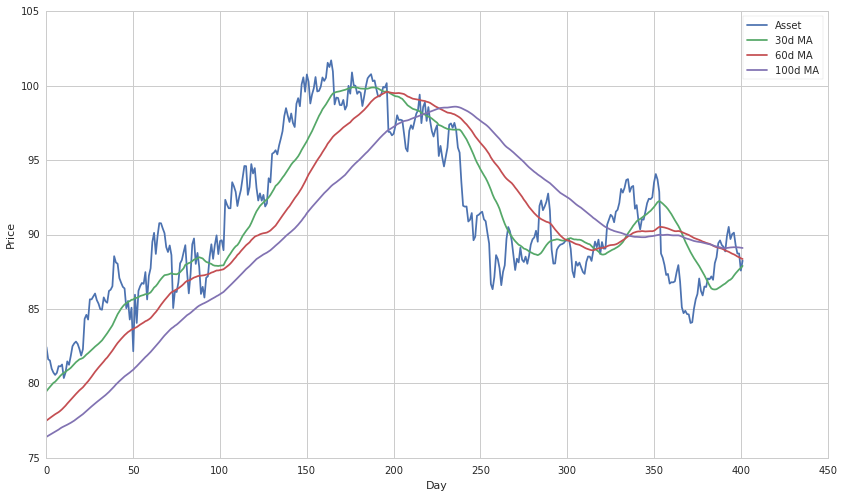

In [5]:
# Load the pricing data for a stock
start = '2011-01-01'
end = '2013-01-01'
pricing = get_pricing('MCD', fields='price', start_date=start, end_date=end)

# Compute rolling averages for various window lengths
mu_30d = pd.rolling_mean(pricing, window=30)
mu_60d = pd.rolling_mean(pricing, window=60)
mu_100d = pd.rolling_mean(pricing, window=100)

# Plot asset pricing data with rolling means from the 100th day, when all the means become available
plt.plot(pricing[100:], label='Asset')
plt.plot(mu_30d[100:], label='30d MA')
plt.plot(mu_60d[100:], label='60d MA')
plt.plot(mu_100d[100:], label='100d MA')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend();

If we pick the length based on which seems best - say, on how well our model or algorithm performs - we are overfitting. Below we have a simple trading algorithm which bets on the stock price reverting to the rolling mean (for more details, check out the mean reversion notebook). We use the performance of this algorithm to score window lengths and find the best one. However, when we consider a different timeframe, this window length is far from optimal. This is because our original choice was overfitted to the sample data.

In [6]:
# Trade using a simple mean-reversion strategy
def trade(stock, length):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if length == 0:
        return 0
    
    # Compute rolling mean and rolling standard deviation
    mu = pd.rolling_mean(stock, window=length)
    std = pd.rolling_std(stock, window=length)
    
    # Compute the z-scores for each day using the historical data up to that day
    zscores = (stock - mu)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    count = 0
    for i in range(len(stock)):
        # Sell short if the z-score is > 1
        if zscores[i] > 1:
            money += stock[i]
            count -= 1
        # Buy long if the z-score is < 1
        elif zscores[i] < -1:
            money -= stock[i]
            count += 1
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscores[i]) < 0.5:
            money += count*stock[i]
            count = 0
    return money

In [7]:
# Find the window length 0-254 that gives the highest returns using this strategy
length_scores = [trade(pricing, l) for l in range(255)]
best_length = np.argmax(length_scores)
print 'Best window length:', best_length

Best window length: 11


In [8]:
# Get pricing data for a different timeframe
start2 = '2013-01-01'
end2 = '2015-01-01'
pricing2 = get_pricing('MCD', fields='price', start_date=start2, end_date=end2)

# Find the returns during this period using what we think is the best window length
length_scores2 = [trade(pricing2, l) for l in range(255)]
print best_length, 'day window:', length_scores2[best_length]

# Find the best window length based on this dataset, and the returns using this window length
best_length2 = np.argmax(length_scores2)
print best_length2, 'day window:', length_scores2[best_length2]

11 day window: 52.1242
190 day window: 468.127


Clearly fitting to our sample data doesn't always give good results in the future. Just for fun, let's plot the length scores computed from the two different timeframes:

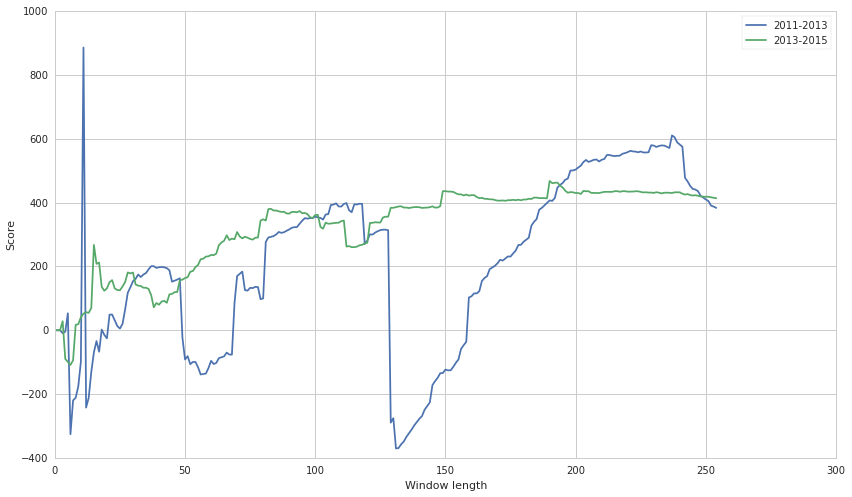

In [9]:
plt.plot(length_scores)
plt.plot(length_scores2)
plt.xlabel('Window length')
plt.ylabel('Score')
plt.legend(['2011-2013', '2013-2015']);

To avoid overfitting, we can use economic reasoning or the nature of our algorithm to pick our window length. We can also use Kalman filters, which do not require us to specify a length; this method is covered in another notebook.

#Avoiding overfitting

We can try to avoid overfitting by taking large samples, choosing reasonable and simple models, and not cherry-picking parameters to fit the data; but just running two backtests is already overfitting.

##Out of Sample Testing

To make sure we haven't broken our model with overfitting, we have to out of sample. That is, we need to gather data that we did not use in constructing the model, and test whether our model continues to work. If we cannot gather large amounts of additional data at will, we should split the sample we have into two parts, of which one is reserved for testing only.

###Common Mistake: Abusing Out of Sample Data

Sometimes people will construct a model on in-sample data, test on out-of-sample data, and conclude it doesn't work. They will then repeat this process until they find a model that works. This is still overfitting, as you have no overfit the model to the out-of-sample data by using it many times, and when you actually test on true out-of-sample data your model will likely break down.

###Cross Validation

Cross validation is the process of splitting your data into n parts, then estimating optimal parameters for n-1 parts combined and testing on the final part. By doing this n times, one for each part held out, we can establish how stable our parameter estimates are and how predictive they are on data not from the original set.

##Information Criterion

Information criterion are a rigorous statistical way to test if the amount of complexity in your model is worth the extra predictive power. The test favors simpler models and will tell you if you are introducing a large amount of complexity without much return. One of the most common methods is [Akaike Information Criterion.](https://en.wikipedia.org/wiki/Akaike_information_criterion)